In [1]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt


In [2]:
mat = scipy.io.loadmat('binaryalphadigs.mat')
data = np.array(mat['dat'])

In [3]:
# lire_alpha_digits
def read_alpha_digits(data, digits):
    """Read digits from the AlphaDigits dataset

    Parameters
    ----------
    data : np.array
    digits : List[int]
        Indexes of the digit classes to read

    Returns
    -------
    np.array
        Array of all the samples from requested digits, in binary array form 
    """    
    read_data = np.take(data.copy(), digits, axis=0)
    read_data = np.reshape(read_data, (len(digits) * read_data.shape[1]))
    return np.array(list(read_data))

# read_alpha_digits(data, [10, 11, 12])

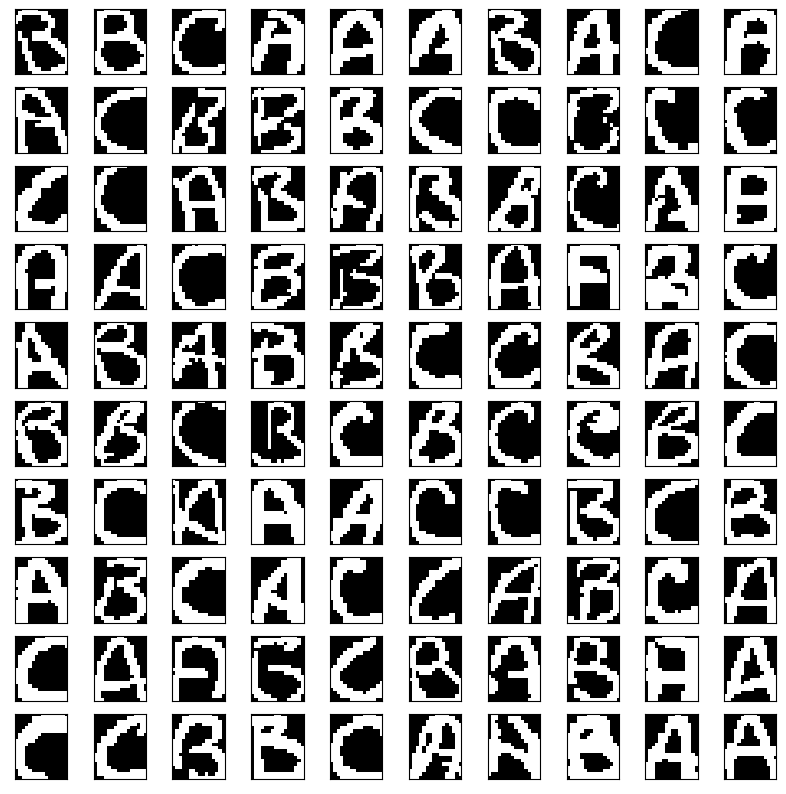

In [4]:
def display_samples(X, n_rows = 10, n_cols = 10, fig_x=10, fig_y=10):
    """
    Display a grid of samples.
    Samples are chosen randomly if there are more samples than n_rows X n_cols.
    """

    # Configs
    plt.figure(figsize=(fig_x,fig_y)) ## Create figure
    n = X.shape[0] # Obtain number of samples to display

    if n <= n_rows * n_cols: 
        # If number of samples fits in the columns/rows
        samples_idx = np.arange(n)
        if n < n_rows * n_cols:
            n_rows = n // n_cols + 1
    else: 
        # If not, choose randomly which images to show
        samples_idx = np.random.choice(n, size=n_rows * n_cols, replace=False)

    # for i in range(1, X.shape[0]):
    for k, idx in enumerate(samples_idx):
        plt.subplot(n_rows, n_cols, k+1)
        plt.imshow(digits[idx], cmap=plt.get_cmap('gray'))

        # Hide ticks
        # plt.axis('off')
        plt.xticks([], [])
        plt.yticks([], [])

    plt.show()


digits = read_alpha_digits(data, [10, 11, 12])
display_samples(digits)

In [71]:
class RBM():
    def __init__(self, p, q) -> None:
        """[Restricted Boltzmann Machine](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)

        Parameters
        ----------
        p : int
            Dimensionality of each sample (width X height)
        q : int
            Hyperparameter - size of the latent variables (hidden units)
        """        
        # Initialize biases (a, b) and weight matrix (w)
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.w = np.zeros((p, q))
        self.p = p
        self.q = q

    def encode(self, X):
        """Encode data X into latent (hidden) vector H
        n: samples per batch
        p: dimensionality of one sample (vector of observations)
        q: dimensionality of one hidden vector

        Parameters
        ----------
        X : np.array (n x p) 
            (Batch of) data to encode

        Returns
        -------
        H : np.array (n x q) 
            Latent vector
        """
        
        H = 1/ (1 + np.exp( -(X @ self.w + self.b)) )
        return H
        # pass

    def decode(self, H):
        """Decode latent (hidden) vector H into vector X
        n: samples per batch
        p: dimensionality of one sample (vector of observations)
        q: dimensionality of one hidden vector

        Parameters
        ----------
        H : np.array (n x q) 
            Latent vector to decode

        Returns
        -------
        X : np.array (n x p) 
            (Batch of) decoded data
        """
        X_rec = 1/ (1 + np.exp( -(H @ self.w.T + self.a)) )
        return X_rec
        # pass

    def train_RBM(self, x, batch_size, n_epoch=5, eps=0.1, verbose=False):
        """Train the RBM

        Parameters
        ----------
        x : np.array
            Input data, as np.ALLOW_THREADSarray of binary np.arrays
        batch_size : int
            Amount of data to be used for one gradient ascent step
        n_epoch : int, optional
            Number of epochs, by default 5
        eps : float, optional
            Learning rate, by default 0.1
        """        
        for epoch in range(n_epoch):
            if verbose: print(f"Epoch: {epoch+1}/{n_epoch}")
            # Random permutation so that the epoch is not the same at each time
            x = np.random.permutation(x)
            for batch_start in range(0, x.shape[0], batch_size):
                # if verbose: print(f"New batch with start index: {batch_start}")
                
                # Create batch
                x_batch = x[batch_start : min(x.shape[0], batch_start+batch_size)] # Deal w/ scenario of batch_size not diviser of nb_epoch
                sz_batch = x_batch.shape[0]
                
                # Initialize v0
                v0 = x_batch # sz_batch x p
                
                p_h_v0 = self.encode(v0) # sz_batch x q

                # Sample h0 from the obtained distribution p(h|v0)
                h0 = (np.random.random((sz_batch, self.q)) < p_h_v0) * 1 # sz_batch x q

                p_v_h0 = self.decode(h0) # sz_batch x p

                # Sample v1 from the obtained distribution p(v|h0)
                v1 = (np.random.random((sz_batch, self.p)) < p_v_h0) * 1 # sz_batch x p

                p_h_v1 = self.encode(v1) # sz_batch x q

                # Obtain gradients
                grad_a = np.sum(v0 - v1, axis=0) # p
                grad_b = np.sum(p_h_v0 - p_h_v1, axis=0) # q
                grad_w = v0.T @ p_h_v0 - v1.T @ p_h_v1 # p x q
                # Gradient ascent
                self.a += eps/sz_batch * grad_a
                self.b += eps/sz_batch * grad_b
                self.w += eps/sz_batch * grad_w

            # We won't evaluate the loss function, because we wouldn't be able to calculate it
            # What we do instead is to obtain the reconstruction error
            H = self.encode(x)
            x_reconst = self.decode(H)
            if verbose: print("Reconstruction error: ", np.mean(np.power(x - x_reconst, 2)))

    def generate_data(self, nb_data, nb_iter_gibbs=2):
        """
        Generate data based on Gibbs sampling
        """

        # Initialize the Gibbs sampler
        v = (np.random.random((nb_data, self.p)) < 0.5) * 1
        # We can also change the parameter of the Bernoulli at each time, to avoid bias in the initialization
        # v = (rand(p) < rand()) * 1

        for iter in range(nb_iter_gibbs):
            h = (np.random.random((nb_data, self.q)) < self.encode(v)) * 1
            v = (np.random.random((nb_data, self.p)) < self.decode(h)) * 1
            
        images = np.reshape(v, (nb_data, 20, 16))
        display_samples(images)
        return images




## Test bench

In [72]:
digits = read_alpha_digits(data, [10])

In [73]:
# display_samples(digits)
print(digits.shape)

(39, 20, 16)


In [74]:
digits_vecs = digits.reshape(39,20*16)

print(digits_vecs.shape)
# print(digits.shape)

(39, 320)


In [75]:
# ---------
# Constants
# ---------
# Data dample dim
p = 20*16 # For Binary AlphaDigits
# Latent vector dim
q = 100

rbm = RBM(p,q)
rbm.train_RBM(digits_vecs, batch_size=4, n_epoch=100, verbose=True)

Epoch: 1/100
Reconstruction error:  0.20507954253254332
Epoch: 2/100
Reconstruction error:  0.19994135161525858
Epoch: 3/100
Reconstruction error:  0.19515454924548656
Epoch: 4/100
Reconstruction error:  0.19145715913183486
Epoch: 5/100
Reconstruction error:  0.1892031155620782
Epoch: 6/100
Reconstruction error:  0.18891400117293067
Epoch: 7/100
Reconstruction error:  0.18707383576697645
Epoch: 8/100
Reconstruction error:  0.18577636751015966
Epoch: 9/100
Reconstruction error:  0.18650583362604634
Epoch: 10/100
Reconstruction error:  0.18600313645224342
Epoch: 11/100
Reconstruction error:  0.1836572692921764
Epoch: 12/100
Reconstruction error:  0.18495111357957592
Epoch: 13/100
Reconstruction error:  0.18225639209810224
Epoch: 14/100
Reconstruction error:  0.1823263730863616
Epoch: 15/100
Reconstruction error:  0.1810206343957743
Epoch: 16/100
Reconstruction error:  0.18007097751754195
Epoch: 17/100
Reconstruction error:  0.1801506928535096
Epoch: 18/100
Reconstruction error:  0.179914

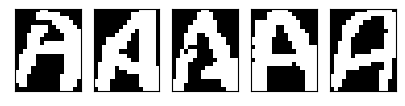

In [76]:
out = rbm.generate_data(5, nb_iter_gibbs=5)